# First Laboratory of Machine Learning per il Calcolo Sceintifico
In this notebook, we want to create the network from the paper "Error bounds for approximations with deep ReLU networks" by D. Yarotsky (Neural Netowrks, 2017, https://doi.org/10.1016/j.neunet.2017.07.002).



## Step zero: libraries

Install  Python (https://www.python.org/)

And the following libraries:

-PyTorch (https://pytorch.org/)

-Numpy (https://numpy.org/)

-Matplotlib (https://matplotlib.org/)


In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)


I'm using:  cpu


## First step: Define $\Phi^\wedge$ using torch Tensor 
Define the weights and the bias of the NN $\Phi^\wedge$ with ReLU activation, seen during the lecutres that emulates $F_1$ and plot in on [0,1] 
$$
F_1 : x\mapsto 
\begin{cases}
2x &x\in (0, 1/2]\\
2-2x &x \in (1/2, 1)\\
0 &\text{elsewhere.}
\end{cases}
$$
We want to define the hidden weight $W_1 \in \mathbb{R}^{3\times 1}$ and bias $b\in \mathbb{R}^{1\times 3}$ and the output weight $W_2\in \mathbb{R}^{1\times 3}$. The NN then will be the map
$$
x\mapsto \left[\mathrm{ReLU}(xW_1^\top + b)\right] W_2^\top
$$
where $x \in \mathbb{R}^{N\times 1}$ can be a vector of $N$ points in $[0,1]$. Note that we choose the formulation above to follow the format implemented in `torch.nn.linear`, see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html. 

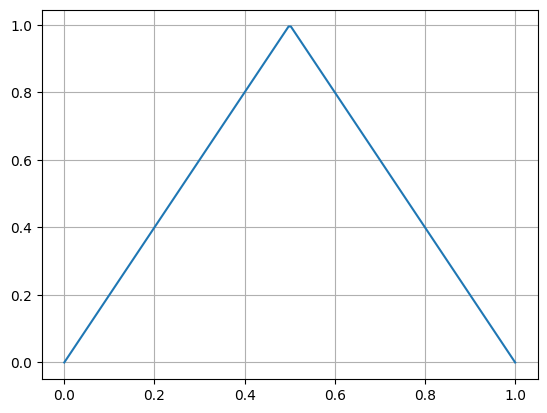

In [2]:
input_weight_mat = torch.tensor([2.0, 2.0, 2.0]) # this should be W_1 
input_bias_vec = torch.tensor([0.0, -1.0, -2.0]) # b
output_weight_mat =torch.tensor([1.0, -2.0, 1.0]) # this should be W_2

with torch.inference_mode(): #to disable gradient computations, which conflicts with plotting
    x = torch.linspace(0, 1, 200).unsqueeze(-1)
    y = torch.relu(x @ input_weight_mat.unsqueeze(0) + input_bias_vec.unsqueeze(0)) @ output_weight_mat.unsqueeze(-1)
    
    # implement the function above. you can use torch.relu(...). Matrix-matrix product is done with the @ operator

    x_np = x.cpu()
    
    plt.plot(x_np, y.squeeze().cpu(), label='f')
    plt.grid()
    plt.show()

We now do the same thing using `torch.nn.Linear`

hidden layer weights shape; torch.Size([3, 1])
hidden layer bias shape; torch.Size([3])
output layer weight shape; torch.Size([3])


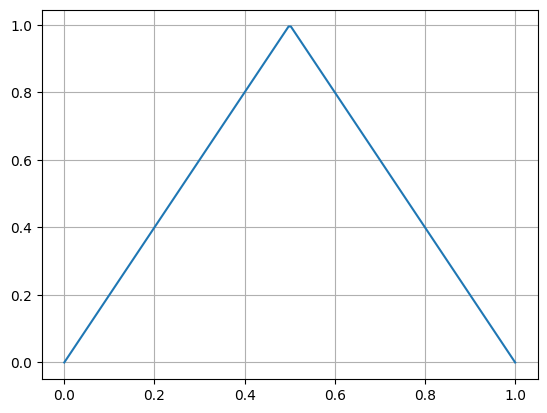

In [3]:
hidden_layer = torch.nn.Linear(3,1, bias = True) # complete with the right dimensions
output_layer = torch.nn.Linear(1,1 , bias=False) # complete with the right dimensions

hidden_layer.weight = torch.nn.Parameter( torch.tensor([[2.0], [2.0], [2.0]] ) ) #complete with the right mat
hidden_layer.bias = torch.nn.Parameter(torch.tensor([0.0, -1.0, -2.0] )) #complete with the right mat
output_layer.weight = torch.nn.Parameter( torch.tensor([1.0, -2.0, 1.0])) #complete with the right mat

print("hidden layer weights shape;" , hidden_layer.weight.shape)
print("hidden layer bias shape;" , hidden_layer.bias.shape)

print("output layer weight shape;" , output_layer.weight.shape)

with torch.inference_mode():
    x = torch.linspace(0, 1, 200).unsqueeze(-1)
    hid = hidden_layer(x)
    y = output_layer(torch.relu(hidden_layer(x)))
    
     # use hidden_layer, output_layer, and torch.relu here. Do not use hidden_layer.weight, hidden_layer.bias, etc.

    x_np = x.cpu()
    
    plt.plot(x_np, y.squeeze().cpu(), label='f')
    plt.grid()
    plt.show()

## Second step: define a general Feed-Forward Neural Network

Complete the following Python class of a FNN (This will be used in future laboratories!)

In [ ]:
class DeepNet(torch.nn.Module):
    def __init__(self, activation, n_input, n_hidden=None, n_output=None):
        """
        construct a NN with
        activation: activation function
        n_input: input dimension
        n_hidden: list of hidden layer widths
        n_output: output dim
        example:  NN = DeepNet(torch.tanh, 2, [4, 3, 4], 1)
        """
        super(DeepNet, self).__init__()  # Constructor of the super class torch.nn.Module
        torch.manual_seed(0) # set the seed for reproducibility
        self.dim_in = n_input # input dimension (given as arg in constructor)
        self.activation = activation # activation function (given as arg in constructor)
        self.hidden = torch.nn.ModuleList() #initialize the inner layers
        if n_hidden is not None:
            self.L = len(n_hidden)# number of hidden layers
            self.widths = n_hidden # the list given as argument in the constructor
            self.hidden.append(torch.nn.Linear(self.dim_in, self.widths[0]) ) # the input layer, as a torch.nn.Linear
            torch.nn.init.xavier_normal_(self.hidden[0].weight)
            torch.nn.init.normal_(self.hidden[0].bias)
            for i in range(1, self.L):
                self.hidden.append(torch.nn.Linear(self.widths[i-1], self.widths[i]) ) # the hidden layers, as torch.nn.Linear
                torch.nn.init.xavier_normal_(self.hidden[i].weight)
                torch.nn.init.normal_(self.hidden[i].bias)
        else:
            self.L = 0

        if n_output is not None:
            self.dim_out = n_output # output dimension
            self.output = torch.nn.Linear(self.widths[-1], self.dim_out) # the output layer as a torch.nn.Linear - no bias here
            torch.nn.init.xavier_normal_(self.output.weight)
        else:
            self.output = None

    def forward(self, x):
        """
        Given input vector x produces the output of the NN
        """
        if x.dim() == 1:
            x = x.unsqueeze(-1) # add a dimension at the end
        for i in range(self.L):
            x =  self.hidden[i](x) # the affine transformation (we have defined this layer in the constructor)
            x =  self.activation(x) # the nonlinearity (we have given the activation in the constructor)
            
        if self.output is not None:
            x = self.output(x) # the output layer
        return x

    #Functions needed for Exercise 2
    
    def set_weight(self, layer, weight_mat, requires_grad=True):
        
        # print(weight_mat.shape, self.hidden[layer].weight.shape)
        assert self.L > layer
        assert weight_mat.shape == self.hidden[layer].weight.shape
        # i assume that weight mat is a torch tensor
        # set the weight matrix for the layer with index "layer". 
        # We have to use torch.nn.Parameter, as we have already done
        self.hidden[layer].weight = torch.nn.Parameter(weight_mat, requires_grad=requires_grad)



    def set_bias(self, layer, bias_mat):
        # print('----------------------------working on the bias')
        # print(bias_mat.shape, self.hidden[layer].bias.shape)
        assert self.L > layer
        assert bias_mat.flatten().shape == self.hidden[layer].bias.shape
        self.hidden[layer].bias = torch.nn.Parameter(bias_mat)
        # the bias of layer with index "layer"
        # again we suppose the bias_mat is a torch tensor

    def set_output_weight(self, weight_mat, requires_grad=True):
        assert self.output is not None
        assert weight_mat.shape == self.output.weight.shape
        # set the output weight
        self.output.weight = torch.nn.Parameter(weight_mat, requires_grad=requires_grad)
    def set_output_bias(self, bias_mat):
        print('----------------------------working on the output bias')
        print(bias_mat.shape)
        print(self.output.bias.shape)
        assert self.output is not None
        assert bias_mat.shape == self.output.bias.shape
        # set the output bias
        self.output.bias = torch.nn.Parameter(bias_mat)


### Create a FNN with 1 layer 3 neurons and ReLU activation function

In [14]:
input_d = 1 # input dim
output_d = 1 # output dim
hidden_layer = [3]# the list of widths of (one) hidden layer
activation_function = torch.relu

FNN = DeepNet(activation_function, input_d, hidden_layer, output_d) # use the class created above
FNN

DeepNet(
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=3, bias=True)
  )
  (output): Linear(in_features=3, out_features=1, bias=True)
)

### Redefine $\Phi^\wedge$ using the FNN defined before  

In [18]:
Phiwedge = FNN 
print("Data about Phiwedge: = ")
print('input dim = ', Phiwedge.dim_in)
print('L = ', Phiwedge.L)
print('output dim = ', Phiwedge.dim_out)
print('hidden widths = ', Phiwedge.widths)


input_weight_mat = torch.tensor([2.0, 2.0, 2.0]) # this should be W_1 
input_bias_vec = torch.tensor([0.0, -1.0, -2.0]) # b
output_weight_mat =torch.tensor([1.0, -2.0, 1.0]) # this should be W_2

Phiwedge.set_weight(0, input_weight_mat.unsqueeze(1)) # set the hidden weight
Phiwedge.set_bias(0, input_bias_vec) # set the hidden bias
Phiwedge.set_output_weight(output_weight_mat.unsqueeze(0))
Phiwedge.set_output_bias(torch.tensor([0,0,0]).unsqueeze(0)) # no bias in the output layer

# set the hidden weight/bias and the output weight of Phiwedge

Data about Phiwedge: = 
input dim =  1
L =  1
output dim =  1
hidden widths =  [3]


AssertionError: 

Plot the output of the NN in [0,1].

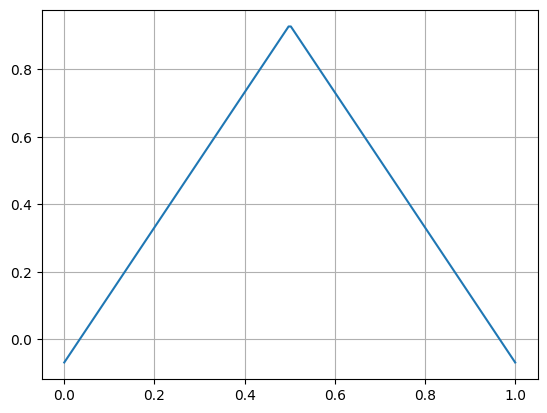

In [7]:
with torch.inference_mode():
    x = torch.linspace(0, 1, 200)
    y = Phiwedge.forward(x)

    x_np = x.cpu()
    
    plt.plot(x_np, y.cpu(), label='f')
    plt.grid()
    plt.show()

## Third step: Concatenation of two Networks
Complete the following code which implements the non-sparse concatenation

In [ ]:
def concatenate(nn1, nn2):
    assert nn1.dim_out == nn2.dim_in
    assert nn1.activation == nn2.activation
    new_L = nn1.L + nn2.L + 1 # numer of hidden layers of concatenated network
    new_widths = nn1.widths + nn2.widths # concatenate the two lists (+ operator in python)
    out_net = DeepNet(nn1.activation, nn1.dim_in, new_widths, nn2.dim_out)# construct the network

    for i in range(nn1.L):
        out_net.set_weight( i, nn1.hidden[i].weight) 
        out_net.set_bias(  i, nn1.hidden[i].bias )
    
    new_weight = nn2.hidden[0].weight@ nn1.output.weight  # compute new weight, which is the product of the first weight of nn2 and the output weight of nn1
    
    out_net.set_weight(nn1.L, new_weight)
    out_net.set_bias(nn1.L, nn2.hidden[0].bias)
    for i in range(1, nn2.L):
        out_net.set_weight(nn1.L + i - 1, nn2.hidden[i].weight)
        out_net.set_bias(nn1.L+ i - 1, nn2.hidden[i].bias)
    
    out_net.set_output_weight( nn2.output.weight )
    
    return out_net

Concatenate the NN $\Phi^\wedge$ defined in the second step 4 time ($F_4 = F_1\circ F_1 \circ F_1 \circ F_1$) 

DeepNet(
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1-4): 4 x Linear(in_features=3, out_features=3, bias=True)
  )
  (output): Linear(in_features=3, out_features=1, bias=True)
)


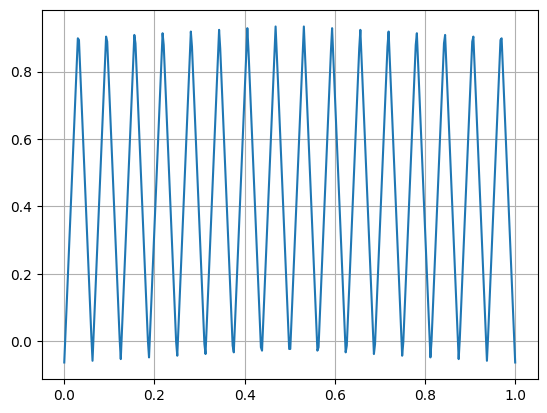

In [11]:
F4 = concatenate(concatenate(concatenate(concatenate(Phiwedge, Phiwedge), Phiwedge), Phiwedge), Phiwedge) # concatenate Phiwedge 4 times
print(F4)
with torch.inference_mode():
    x = torch.linspace(0, 1, 400)
    x_np = x.cpu().numpy()

    # plot F4(x)
    y = F4.forward(x)

    
    plt.plot(x_np, y.cpu(), label='f')
    plt.grid()
    plt.show()


## Fourth step: Define the Yarotsky Network 

We now want to construct the network from Yarotsky's paper. Defining by $F_n$ the $n$-fold composition of $\Phi^\wedge$, we use the fact that
$$
x - \sum_{k=1}^N \frac{F_k(x)}{4^k} \to x^2, \qquad \text{as }N\to\infty,
$$ 
for all $x\in[0,1]$. The network therefore uses a non-standard architecture, as shown in this picture:

<center>
    <img src="./Yarotsky-arch.png" alt="Architecture">
</center>

In [10]:
class YarotskyNet(DeepNet):
    def __init__(self, net, out_weights):
        """
        Initialize by copying a net given as input, and a vector of
        weights that are the weights of the skip connections
        """
        super(YarotskyNet, self).__init__(net.activation, net.dim_in, net.widths, net.dim_out)
        self.out_weights = # these are the weights of the skip connections, and are passed as an argument to the constructor
        for i in range(net.L):
            self.hidden[i] = # copy the hidden weights of the NN given as argument (net)
        
        self.output = # copy also the output weight
        
        assert len(out_weights) == len(net.widths) + 1
 
    def forward(self, x):
        if x.dim() == 1:
            x = x[:, None]
        
        y = # the first skip connection goes straight from the input
        for i in range(self.L):
            x = # affine transformation
            x = # activation
            y = # skip connection to the output (use self.output_weights[i+1] here)
        return y

SyntaxError: invalid syntax (675709268.py, line 8)

Define a Yarotsky network, with depth = 3. Plot the output of the Yarotsky network over [0,1] and compare it with respect to $x^2$. Then evaluate the $L^2$ error

In [ ]:
with torch.inference_mode():
    depth = 3

    out_weights = # define the weights of the skip connections to the output for Yarotsy's network
   

    basenet = Phiwedge
    for j in range(depth-2):
        # concatenate the Phiwedge network, to obtain a network with the right weights but no skip connections
        

    squarenet = # construct the network with the class we have defined, copying from the one we have concatenated, but also putting in skip connections

    x = torch.linspace(0, 1, 100)
    x_np = x.cpu().numpy()
    
    y = # complete

    


    plt.plot(x_np, y.cpu().numpy(), label='Yarotsky')
    plt.plot(x_np, x_np**2, 'r-.',label = '$x^2$')
    plt.grid()
    plt.legend()
    plt.show()

    print(f'L2 error: {np.linalg.norm(y.cpu().numpy().flatten()-x_np**2)/10:4e}')

Evalute the $L^2$ error of the Yarotsky Network with respect to $x^2$, as a function of the depth of the network

In [ ]:
def compute_err(depth):

    # define squarenet as above 
    
    Npts = 10**6
    x = torch.linspace(0, 1, Npts)
    y = squarenet(x)
    x_np = x.cpu().detach().numpy()

    return np.linalg.norm(y.cpu().detach().numpy().flatten()-x_np**2)/np.sqrt(Npts)

err = []
all_depths = range(3, 15)
for depth in all_depths:
    err.append(compute_err(depth))

plt.semilogy(all_depths, err, 'o-')
plt.grid()
plt.xlabel("Depth")
plt.ylabel("$L^2$ error")
plt.show()

err